# Feature Extractors for Generative Models

Using device: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.96MB/s]


Epoch [1/10], Loss: 0.7201
Epoch [2/10], Loss: 0.3264
Epoch [3/10], Loss: 0.2313
Epoch [4/10], Loss: 0.1807
Epoch [5/10], Loss: 0.1534
Epoch [6/10], Loss: 0.1139
Epoch [7/10], Loss: 0.1053
Epoch [8/10], Loss: 0.0861
Epoch [9/10], Loss: 0.0696
Epoch [10/10], Loss: 0.0686


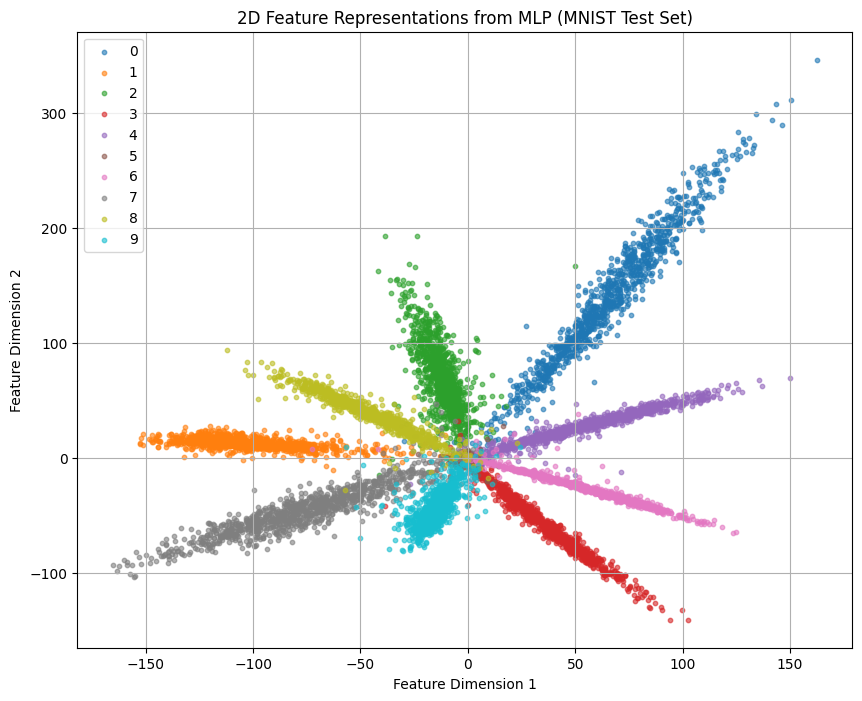

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 2. Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.feature_layer = nn.Linear(128, 2)  # 2D features
        self.classifier = nn.Linear(2, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        features = self.feature_layer(x)
        out = self.classifier(features)
        return out, features

model = MLP().to(device)

# 3. Training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train(model, loader):
    model.train()
    for epoch in range(10):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss / len(loader):.4f}")

train(model, train_loader)

# 4. Extract 2D features from test set
def extract_features(model, loader):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            _, features = model(images)
            all_features.append(features.cpu())
            all_labels.append(labels)

    return torch.cat(all_features, dim=0), torch.cat(all_labels, dim=0)

features, labels = extract_features(model, test_loader)

# 5. Scatter plot
def plot_features(features, labels):
    features = features.numpy()
    labels = labels.numpy()
    plt.figure(figsize=(10, 8))
    for digit in range(10):
        idxs = labels == digit
        plt.scatter(features[idxs, 0], features[idxs, 1], label=str(digit), alpha=0.6, s=10)

    plt.legend()
    plt.title("2D Feature Representations from MLP (MNIST Test Set)")
    plt.xlabel("Feature Dimension 1")
    plt.ylabel("Feature Dimension 2")
    plt.grid(True)
    plt.show()

plot_features(features, labels)

Using device: cuda
Epoch [1/10], Loss: 0.6191
Epoch [2/10], Loss: 0.1905
Epoch [3/10], Loss: 0.1265
Epoch [4/10], Loss: 0.0929
Epoch [5/10], Loss: 0.0731
Epoch [6/10], Loss: 0.0570
Epoch [7/10], Loss: 0.0464
Epoch [8/10], Loss: 0.0370
Epoch [9/10], Loss: 0.0302
Epoch [10/10], Loss: 0.0307


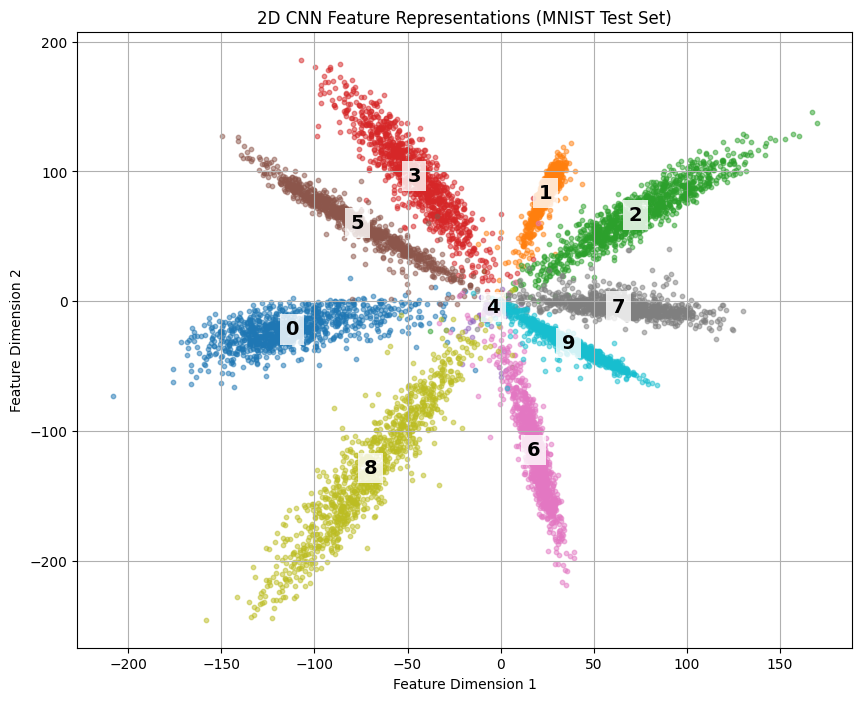

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset and loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.feature_layer = nn.Linear(128, 2)
        self.classifier = nn.Linear(2, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # [B, 32, 14, 14]
        x = self.pool2(F.relu(self.conv2(x)))  # [B, 64, 7, 7]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        features = self.feature_layer(x)
        out = self.classifier(features)
        return out, features

model = CNN().to(device)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, loader):
    model.train()
    for epoch in range(10):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss / len(loader):.4f}")

train(model, train_loader)

# Extract 2D features
def extract_features(model, loader):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            _, features = model(images)
            all_features.append(features.cpu())
            all_labels.append(labels)

    return torch.cat(all_features, dim=0), torch.cat(all_labels, dim=0)

features, labels = extract_features(model, test_loader)

# Scatter plot with cluster centers labeled
def plot_features(features, labels):
    features = features.numpy()
    labels = labels.numpy()
    plt.figure(figsize=(10, 8))

    for digit in range(10):
        idxs = labels == digit
        x_vals = features[idxs, 0]
        y_vals = features[idxs, 1]
        plt.scatter(x_vals, y_vals, label=str(digit), alpha=0.5, s=10)

        # Cluster center
        center_x = np.mean(x_vals)
        center_y = np.mean(y_vals)
        plt.text(center_x, center_y, str(digit), fontsize=14, weight='bold',
                 ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    plt.title("2D CNN Feature Representations (MNIST Test Set)")
    plt.xlabel("Feature Dimension 1")
    plt.ylabel("Feature Dimension 2")
    plt.grid(True)
    plt.show()

plot_features(features, labels)

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 460kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.81MB/s]


Epoch [1/10], Loss: 0.7268
Epoch [2/10], Loss: 0.6633
Epoch [3/10], Loss: 0.6510
Epoch [4/10], Loss: 0.6440
Epoch [5/10], Loss: 0.6390
Epoch [6/10], Loss: 0.6353
Epoch [7/10], Loss: 0.6327
Epoch [8/10], Loss: 0.6305
Epoch [9/10], Loss: 0.6287
Epoch [10/10], Loss: 0.6258


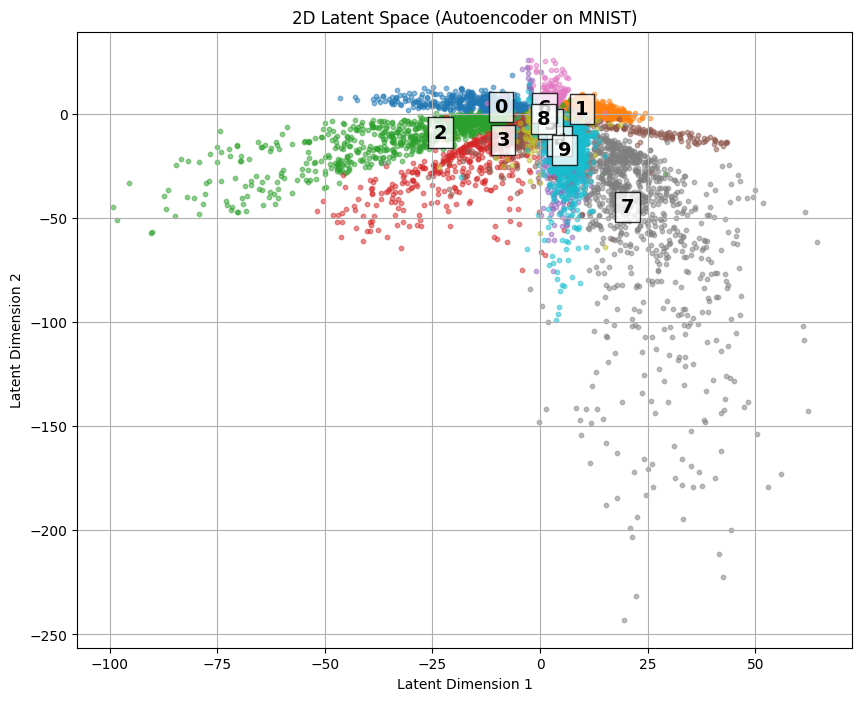

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [B, 64, 7, 7]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # 2D latent vector
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),   # [B, 1, 28, 28]
            nn.Sigmoid()  # For grayscale pixel values between 0 and 1
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
def train(model, loader):
    model.train()
    for epoch in range(10):
        total_loss = 0
        for images, _ in loader:
            images = images.to(device)

            optimizer.zero_grad()
            recon, _ = model(images)

            # Reconstruction loss: How close is the decoded image to the original?
            loss = criterion(recon, images)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss / len(loader):.4f}")

train(autoencoder, train_loader)

# Extract latent features for visualization
def extract_latents(model, loader):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for images, label in loader:
            images = images.to(device)
            _, z = model(images)
            latents.append(z.cpu())
            labels.append(label)
    return torch.cat(latents), torch.cat(labels)

features, labels = extract_latents(autoencoder, test_loader)

# Plot latent space with digit labels at cluster centers
def plot_latents(features, labels):
    features = features.numpy()
    labels = labels.numpy()
    plt.figure(figsize=(10, 8))
    for digit in range(10):
        idxs = labels == digit
        x_vals = features[idxs, 0]
        y_vals = features[idxs, 1]
        plt.scatter(x_vals, y_vals, label=str(digit), alpha=0.5, s=10)

        center_x = np.mean(x_vals)
        center_y = np.mean(y_vals)
        plt.text(center_x, center_y, str(digit), fontsize=14, weight='bold',
                 ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.8))

    plt.title("2D Latent Space (Autoencoder on MNIST)")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.show()

plot_latents(features, labels)

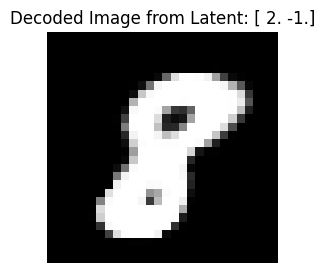

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set this to your desired 2D latent vector (example: center of a cluster)
custom_latent = np.array([2.0, -1.0], dtype=np.float32)

# Convert to tensor
z = torch.tensor(custom_latent).unsqueeze(0).to(device)  # shape [1, 2]

# Decode
autoencoder.eval()
with torch.no_grad():
    decoded_img = autoencoder.decoder(z).cpu().squeeze().numpy()

# Plot image
plt.figure(figsize=(3, 3))
plt.imshow(decoded_img, cmap='gray')
plt.title(f"Decoded Image from Latent: {custom_latent}")
plt.axis('off')
plt.show()

Using device: cuda
Epoch [1/10], Loss: 591.1454
Epoch [2/10], Loss: 541.8582
Epoch [3/10], Loss: 533.9161
Epoch [4/10], Loss: 530.0660
Epoch [5/10], Loss: 527.4918
Epoch [6/10], Loss: 525.5694
Epoch [7/10], Loss: 523.7681
Epoch [8/10], Loss: 522.1676
Epoch [9/10], Loss: 520.7486
Epoch [10/10], Loss: 519.5998


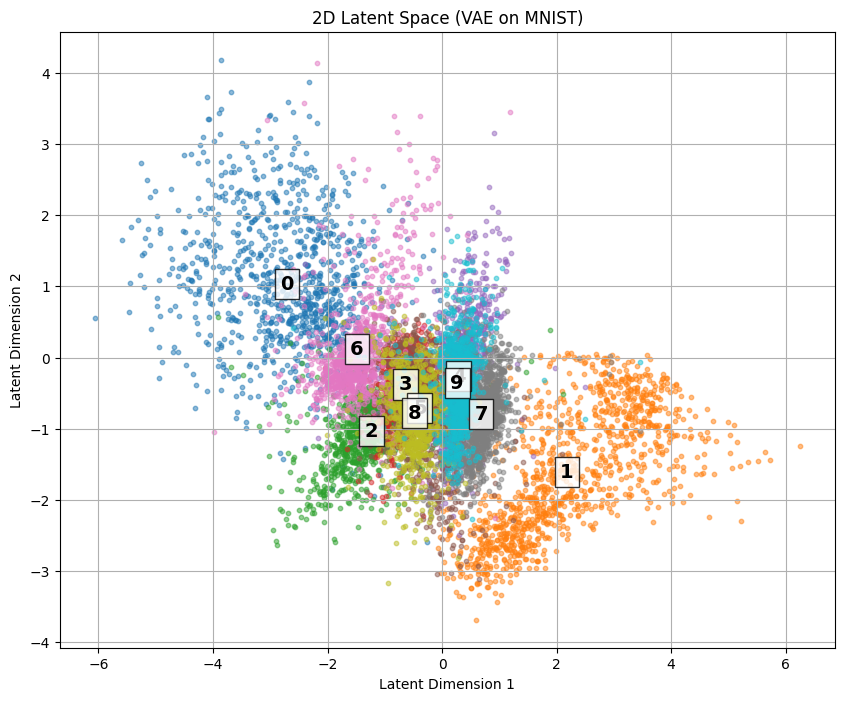

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [B, 64, 7, 7]
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, 2)
        self.fc_logvar = nn.Linear(64 * 7 * 7, 2)

        # Decoder
        self.decoder_input = nn.Linear(2, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),   # [B, 1, 28, 28]
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        out = self.decode(z)
        return out, mu, logvar, z

vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# VAE Loss = Reconstruction + KL Divergence
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # Pixel-wise loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL term
    return recon_loss + kl_div

# Training loop
def train(model, loader):
    model.train()
    for epoch in range(10):
        total_loss = 0
        for images, _ in loader:
            images = images.to(device)
            optimizer.zero_grad()

            recon, mu, logvar, _ = model(images)

            # Loss = reconstruction + KL divergence
            loss = loss_function(recon, images, mu, logvar)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss / len(loader.dataset):.4f}")

train(vae, train_loader)

# Visualize latent space
def extract_latents(model, loader):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for images, label in loader:
            images = images.to(device)
            _, _, _, z = model(images)
            latents.append(z.cpu())
            labels.append(label)
    return torch.cat(latents), torch.cat(labels)

features, labels = extract_latents(vae, test_loader)

def plot_latents(features, labels):
    features = features.numpy()
    labels = labels.numpy()
    plt.figure(figsize=(10, 8))
    for digit in range(10):
        idxs = labels == digit
        x_vals = features[idxs, 0]
        y_vals = features[idxs, 1]
        plt.scatter(x_vals, y_vals, label=str(digit), alpha=0.5, s=10)

        center_x = np.mean(x_vals)
        center_y = np.mean(y_vals)
        plt.text(center_x, center_y, str(digit), fontsize=14, weight='bold',
                 ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.8))

    plt.title("2D Latent Space (VAE on MNIST)")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.show()

plot_latents(features, labels)

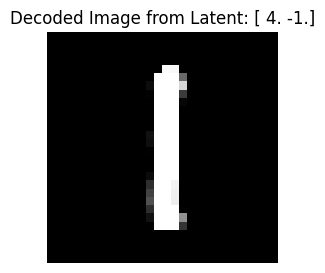

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Example latent point (explore from -4 to 4)
custom_latent = np.array([4.0, -1.0], dtype=np.float32)

# Convert to tensor
z = torch.tensor(custom_latent).unsqueeze(0).to(device)

# Decode to image
vae.eval()
with torch.no_grad():
    decoded_img = vae.decode(z).cpu().squeeze().numpy()

# Plot the decoded image
plt.figure(figsize=(3, 3))
plt.imshow(decoded_img, cmap='gray')
plt.title(f"Decoded Image from Latent: {custom_latent}")
plt.axis('off')
plt.show()